In [355]:
import itertools
import math
from dataclasses import dataclass

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from plotting import label_axes

# Threshold energy calculation for generic process

$$
a + b \to c + d + ...
$$

Given the mass of the projectile (a), the mass and energy of the target (b), the scattering angle and the "added mass" after the process ($\Delta m = \sum_{c,d,...} m - m_a - m_b$), calculate the threshold energy for the projectile.

From invariance of $s$ we write

$$
E_a E_b - \sqrt{E_a^2 - m_a^2} \sqrt{E_b^2 - m_b^2} \cos \theta \ge m_a m_b + \Delta m \left( m_a + m_b + \frac{\Delta m} {2} \right)
$$

Writing in terms of $x \equiv T_a = E_a - m_a$, we get

$$
x + m_a - \alpha \sqrt{x^2 + 2 x m_a} \ge \beta \\
\alpha \equiv \frac{ \sqrt{E_b^2 - m_b^2} \cos \theta }{E_b} \\
\beta \equiv \frac{ m_a m_b + \Delta m \left( m_a + m_b + \frac{\Delta m} {2} \right) } {E_b} \\
\to \alpha \sqrt{x^2 + 2 x m_a} \le x + m_a - \beta
$$

## Movement in one direction

In the case of $\theta \in [0, \pi/2]$ we have $\alpha > 0$. If $x + m_a - \beta < 0$, there are no solutions to the inequality.
If $x + m_a - \beta \ge 0$, we have a quadratic inequality

$$
(\alpha^2 - 1) x^2 + (2 (m_a (\alpha^2 - 1) + \beta)) x - (m_a - \beta)^2 \le 0
$$

The first coefficient is negative, so the parabola's branches go downwards. Denoting it's roots as $x_{1,2}$,
we have the final solution as $x \in ((-\infty, x_1] \cup [x_2, \infty)) \cap [\beta - m_a, \infty)$

## Movement towards each other

In the case of $\theta \in [\pi/2, \pi]$ we have $\alpha < 0$. In this case the inequality can be effectively inverted by writing

$$
| \alpha | \sqrt{x^2 + 2 x m_a} \ge x + m_a - \beta
$$

In this case, on the contrary, $x + m_a - \beta < 0$ is always a solution. In the opposite case $x + m_a - \beta \ge 0$,
we have a similar quadratic inequality with the opposite sign, leading to the final solution
$x \in ( [x_1, x_2]  \cap [\beta - m_a, \infty) ) \cup (- \infty, \beta - m_a] $

## Relativistic limit

The case of $m_a \ll E_a$. This leads to

$$
T_a \ge \frac{ m_a m_b + \Delta m \left( m_a + m_b + \frac{\Delta m} {2} \right) } {E_b - \sqrt{E_b^2 - m_b^2} \cos \theta} - m_a
$$


In [260]:
m_p = const.m_p * const.c**2
m_e = const.m_e * const.c**2

In [291]:
Interval = tuple[u.Quantity[u.eV], u.Quantity[u.eV]]


@dataclass
class EnergyRegion:
    intervals: list[Interval]

    def finite_energies(self) -> u.Quantity[u.eV]:
        all_energies = list(itertools.chain.from_iterable(self.intervals))
        return u.Quantity([e for e in all_energies if np.isfinite(e)])

    @classmethod
    def from_union(cls, a: Interval, b: Interval) -> "EnergyRegion":
        if a[0] > b[0]:
            a, b = b, a
        if b[0] <= a[1]:
            return EnergyRegion(intervals=[(a[0], max(a[1], b[1]))])
        else:
            return EnergyRegion(intervals=[a, b])

    @staticmethod
    def intersection(a: Interval, b: Interval) -> Interval | None:
        start = max(a[0], b[0])
        end = min(a[1], b[1])
        return (start, end) if end > start else None

    def intersect_with(self, other: Interval) -> None:
        maybe_intervals = [self.intersection(i, other) for i in self.intervals]
        self.intervals = [i for i in maybe_intervals if i is not None]


INF = np.inf * u.eV
NEGINF = -np.inf * u.eV


def allowed_energy(
    proj_mass: u.Quantity[u.eV],
    target_mass: u.Quantity[u.eV],
    target_energy: u.Quantity[u.eV],
    scattering_angle: u.Quantity[u.dimensionless_unscaled],
    added_mass: u.Quantity[u.eV],
) -> EnergyRegion:
    alpha = (
        np.sqrt(target_energy**2 - target_mass**2)
        * np.cos(scattering_angle)
        / target_energy
    ).decompose()
    beta = (
        (
            target_mass * proj_mass
            + added_mass * (target_mass + proj_mass + added_mass / 2)
        )
        / target_energy
    ).to(u.eV)
    m_a = proj_mass.to(u.eV)

    a = alpha**2 - 1
    b = 2 * (m_a * (alpha**2 - 1) + beta)
    c = -((m_a - beta) ** 2)
    D = b**2 - 4 * a * c
    if alpha > 0:
        if D < 0:
            solution = EnergyRegion([(NEGINF, INF)])
        elif math.isclose(a, 0.0):
            root = -c / b
            if b > 0:
                solution = EnergyRegion([(NEGINF, root)])
            else:
                solution = EnergyRegion([(root, INF)])
        else:
            root1, root2 = sorted(
                [(-b + sign * np.sqrt(D)) / (2 * a) for sign in (-1, 1)]
            )
            solution = EnergyRegion.from_union((NEGINF, root1), (root2, INF))
        solution.intersect_with((beta - m_a, INF))
        solution.intersect_with((0 * u.eV, INF))
    else:
        if D < 0:
            solution = EnergyRegion([])
        elif math.isclose(a, 0.0):
            root = -c / b
            if b > 0:
                solution = EnergyRegion([(root, INF)])
            else:
                solution = EnergyRegion([(NEGINF, root)])
        else:
            root1, root2 = sorted(
                [(-b + sign * np.sqrt(D)) / (2 * a) for sign in (-1, 1)]
            )
            solution = EnergyRegion([(root1, root2)])
        solution.intersect_with((beta - m_a, INF))
        solution.intervals.append((NEGINF, beta - m_a))
        solution.intersect_with((0 * u.eV, INF))
    return solution


def threshold_energy_relativistic_limit(
    proj_mass: u.Quantity[u.eV],
    target_mass: u.Quantity[u.eV],
    target_energy: u.Quantity[u.eV],
    scattering_angle: u.Quantity[u.dimensionless_unscaled],
    added_mass: u.Quantity[u.eV],
) -> EnergyRegion:
    E_min = max(
        (
            (
                target_mass * proj_mass
                + added_mass * (target_mass + proj_mass + added_mass / 2)
            )
            / (
                (
                    target_energy
                    - np.sqrt(target_energy**2 - target_mass**2)
                    * np.cos(scattering_angle)
                )
            )
        )
        - proj_mass,
        0.0 * u.eV,
    ).to(u.eV)
    return EnergyRegion([(E_min, INF)])

In [290]:
kw = dict(
    proj_mass=m_p,
    target_mass=0.0 * u.eV,
    added_mass=2 * m_e,
    target_energy=1 * u.PeV,
    scattering_angle=np.pi,
)
print(allowed_energy(**kw))
print(threshold_energy_relativistic_limit(**kw))

EnergyRegion(intervals=[(<Quantity 4.58788304e+17 eV>, <Quantity inf eV>)])
EnergyRegion(intervals=[(<Quantity 0. eV>, <Quantity inf eV>)])


In [356]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

RegionSeries = list[tuple[u.Quantity[u.eV], EnergyRegion]]


def plot_threshold_energy(
    proj_mass: u.Quantity[u.eV],
    target_mass: u.Quantity[u.eV],
    added_mass: u.Quantity[u.eV],
    target_kinenergy_limits_lgeV: tuple[float, float],
    label: str,
):
    theta_grid = np.linspace(0, np.pi, 9)
    T_target_grid = np.logspace(*target_kinenergy_limits_lgeV, num=300) * u.eV
    # theta_grid = np.array([np.pi / 4])
    # T_target_grid = np.logspace(*target_kinenergy_limits_lgeV, num=30) * u.eV
    T_target_mult_halfstep = np.sqrt((T_target_grid[1] / T_target_grid[0]).decompose())

    T_max_global = 0 * u.eV
    T_min_global = np.inf * u.eV
    regions_per_theta: list[RegionSeries] = []
    for idx, theta in enumerate(theta_grid):
        regions: RegionSeries = []
        for T in T_target_grid:
            region = allowed_energy(
                proj_mass=proj_mass,
                target_mass=target_mass,
                target_energy=T + target_mass,
                added_mass=added_mass,
                scattering_angle=theta,
            )
            regions.append((T, region))
            T_from_region = region.finite_energies()
            if T_from_region.size > 0:
                T_max_global = max(T_max_global, T_from_region.max())
                if T_from_region.min() > 0:
                    T_min_global = min(T_max_global, T_from_region.min())
        regions_per_theta.append(regions)
    margin = (T_max_global / T_min_global) ** (0.1)
    T_max_global *= margin
    T_min_global /= margin

    _, ax = plt.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")
    cmap = matplotlib.colormaps["turbo"]
    for idx, (theta, regions) in enumerate(zip(theta_grid, regions_per_theta)):
        color = cmap(idx / (theta_grid.size))
        xs = []
        ys = []
        for Ttarget, region in regions:
            for Tproj in region.finite_energies():
                xs.append(Ttarget)
                ys.append(Tproj)
        if xs:
            ax.scatter(
                u.Quantity(xs),
                u.Quantity(ys),
                marker=".",
                color=color,
                label=f"$ \\theta = {theta * 180 / np.pi :.1f}^\\circ $",
            )
        # patches = []
        # for T, region in regions:
        #     T_target_min = T / T_target_mult_halfstep
        #     T_target_max = T * T_target_mult_halfstep
        #     for T_min, T_max in region.intervals:
        #         T_max = min(T_max_global, T_max)
        #         patches.append(
        #             Rectangle(
        #                 (T_target_min.to(u.eV).value, T_min.to(u.eV).value),
        #                 width=T_target_max.to(u.eV).value - T_target_min.to(u.eV).value,
        #                 height=T_max.to(u.eV).value - T_min.to(u.eV).value,
        #                 # color=color,
        #                 # alpha=0.3,
        #             )
        #         )
        # ax.add_collection(
        #     PatchCollection(
        #         patches,
        #         facecolor=color,
        #         alpha=0.3,
        #         label=f"$ \\theta = {theta * 180 / np.pi :.1f}^\\circ $",
        #     ),
        #     autolim=True,
        # )

    label_axes(ax, "T_{\\mathrm{target}}", "T_{\\mathrm{projectile}}")
    # ax.set_ylim(T_min_global, T_max_global)
    # ax.set_xlim(
    #     T_target_grid[0] / T_target_mult_halfstep**2,
    #     T_target_grid[-1] * T_target_mult_halfstep**2,
    # )
    ax.legend()
    if proj_mass > 0:
        ax.axhline(proj_mass, color="k", linestyle="--", linewidth=0.3)
    if target_mass > 0:
        ax.axvline(target_mass, color="k", linestyle="--", linewidth=0.3)
    fmt = lambda E: E.to(u.GeV).to_string(format="latex", precision=2).strip("$")
    label = f"{label}\n$m_a = {fmt(proj_mass)}, m_b = {fmt(target_mass)}, \\Delta m = {fmt(added_mass)} $"
    if label is not None:
        ax.set_title(label)

    ax.axhspan
    return ax

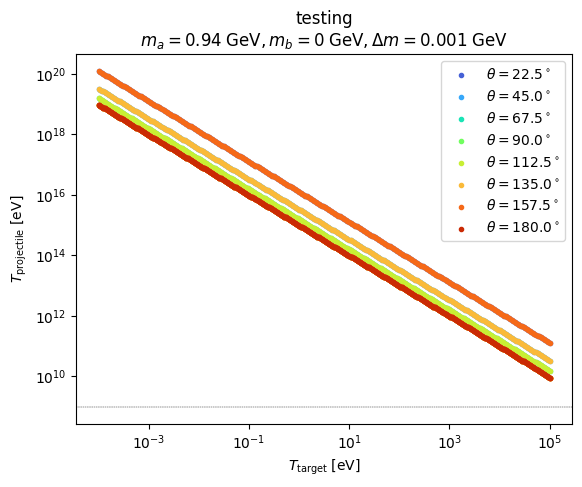

In [358]:
ax = plot_threshold_energy(
    proj_mass=m_p,
    target_mass=0 * u.eV,
    added_mass=2 * m_e,
    target_kinenergy_limits_lgeV=(-4, 5),
    label="testing",
    # label="$ \\gamma + \\gamma \\to 2e^{\\pm} $",
)

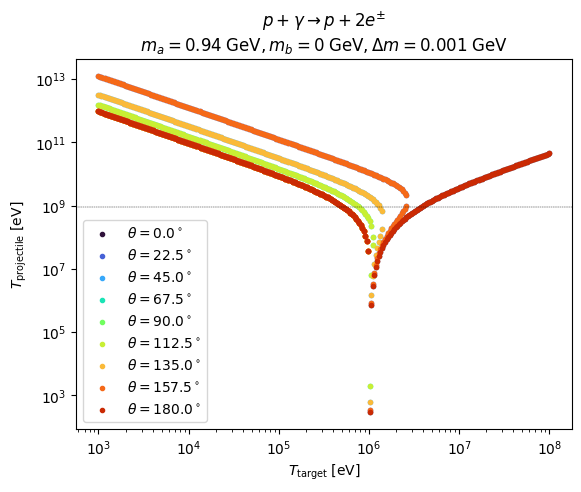

In [359]:
ax = plot_threshold_energy(
    proj_mass=m_p,
    target_mass=0.0 * u.eV,
    added_mass=2 * m_e,
    target_kinenergy_limits_lgeV=(3, 8),
    label="$p + \\gamma \\to p + 2 e^{\\pm}$",
)

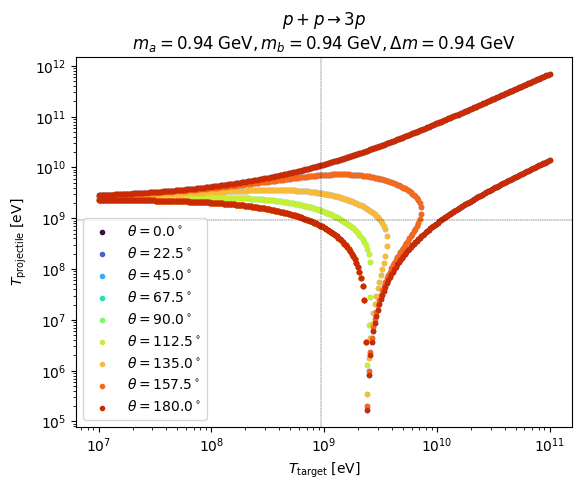

In [360]:
ax = plot_threshold_energy(
    proj_mass=m_p,
    target_mass=m_p,
    added_mass=m_p,
    target_kinenergy_limits_lgeV=(7, 11),
    label="$p + p \\to 3p$",
);